Raphaël RAZAFINDRALAMBO

In [140]:
#!pip install torch
#!pip install h5py
import numpy as np
import torch
import torch.nn as nn
import h5py # pour gérer les formats de données utilisés ici
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

# TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

3 séances de TP sur ce sujet : le 15 novembre (1h00), le 22 novembre (3h) et le 29 novembre (3h).<br>
Deadline : 6 décembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétiques comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:
1/ Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2/ Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3/ Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".


## Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [69]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Traitement du signal et Deep Learning/TP3/samples.hdf5'

data = h5py.File(data_path , 'r')
signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])
#data_30,label_30 = data_from_snr(30,data)
data.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [70]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Regardons la structure des données. Pour ce faire, on se penche sur les données du dataset samples.hdf5 qui est plus restreint mais reste représentatif.

In [71]:
print("Nombre de signaux N: ", len(signals))
print("Nombre de canaux c: ", signals.shape[2], " (partie réelle + partie imaginaire)")
print("Taille des signaux T:", signals.shape[1])

Nombre de signaux N:  200
Nombre de canaux c:  2  (partie réelle + partie imaginaire)
Taille des signaux T: 2048


In [72]:
print("Correspondance labels")
get_labels(h5py.File(data_path , 'r'))

Correspondance labels


{1: 'N-PSK8',
 0: 'N-QAM16',
 2: 'N-QPSK',
 4: 'W-PSK8-V1',
 5: 'W-PSK8-V2',
 3: 'W-QAM16'}

On regarde la répartition des labels pour les données. On remarque que les classes sont équilibrées dans le jeu de données, ce qui est bon signe pour l'apprentissage.

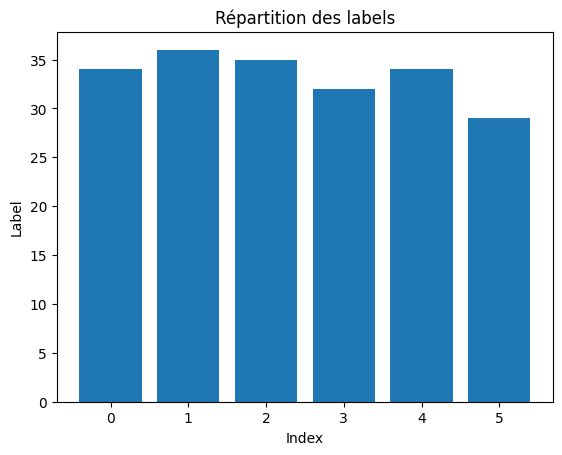

In [73]:
unique_labels, counts = np.unique(labels_id, return_counts=True)
plt.bar(unique_labels, counts)

plt.title('Répartition des labels')
plt.xlabel('Index')
plt.ylabel('Label')

plt.show()

On regarde la répartition des différents SNRs.

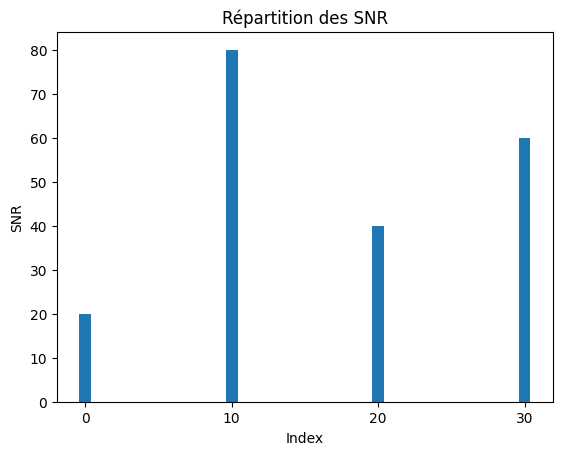

In [74]:
unique_snr, counts_snr = np.unique(snr, return_counts=True)
plt.bar(unique_snr, counts_snr)

plt.title('Répartition des SNR')
plt.xlabel('Index')
plt.xticks(range(0, 31, 10))
plt.ylabel('SNR')

plt.show()

On regarde la tête des signaux en fonction de leur étiquettes, en représentant sur un même graphe la partie réelle et imaginaire. On remarque une différence selon les classes.

In [75]:
def signal_from_label(i,signals):
  return signals[np.where(labels_id==i)[0][0],:,:]

In [76]:
signal1 = signal_from_label(5,signals)
signal1.shape

(2048, 2)

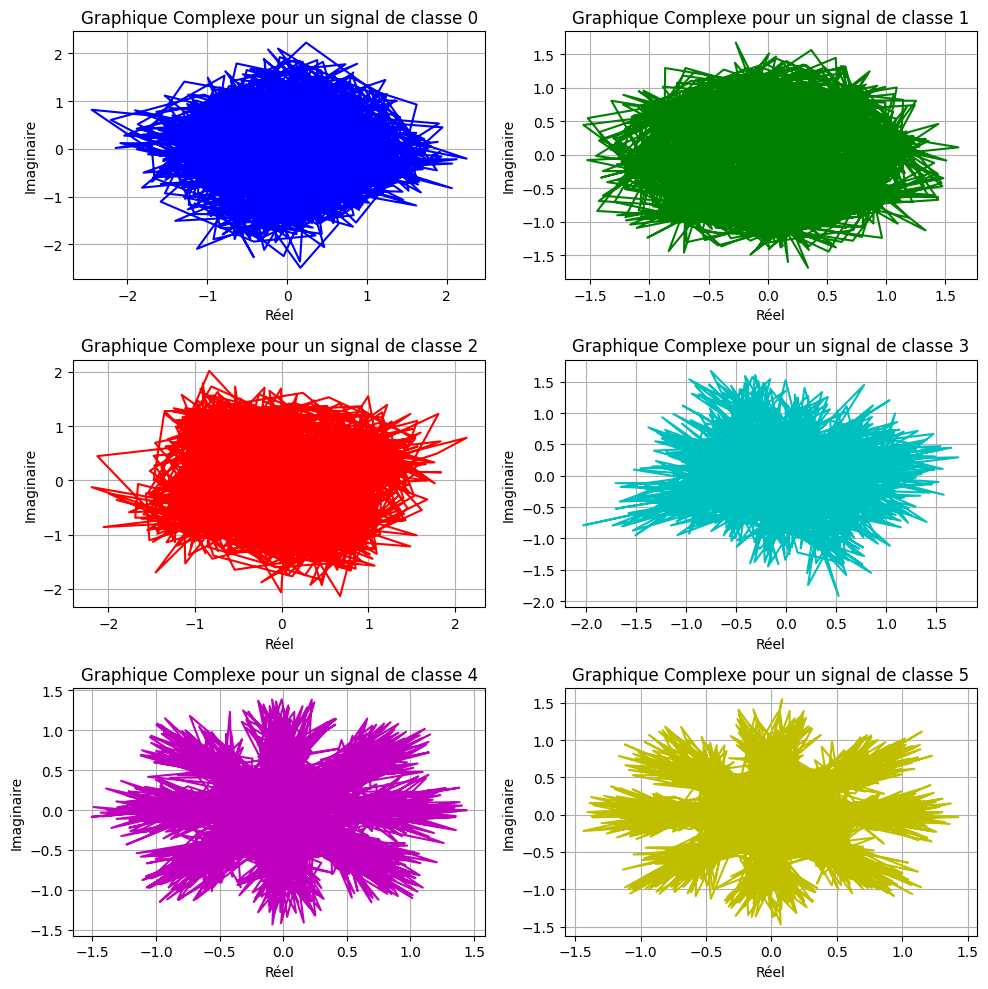

In [77]:
couleurs = ['b', 'g', 'r', 'c', 'm','y']

plt.figure(figsize=(10, 10))

for i in range(6):
    signal = signal_from_label(i,signals)
    plt.subplot(3, 2, i+1)  # 3 lignes, 2 colonnes, position i
    plt.plot(signal[:, 0], signal[:, 1], color=couleurs[i])
    plt.title(f'Graphique Complexe pour un signal de classe {i}')
    plt.xlabel('Réel')
    plt.ylabel('Imaginaire')
    plt.grid(True)

plt.tight_layout()
plt.show()


Les deux dernières classes ont des allures totalement différents des classes antérieures. En effet, on observe une "convexité" dans les représentations des quatres premières classes qui n'est pas présente dans les deux dernières.

On fait de même pour la SNR.

In [78]:
def signal_from_snr(s):
  return signals[np.where(snr==s)[0][0],:,:]

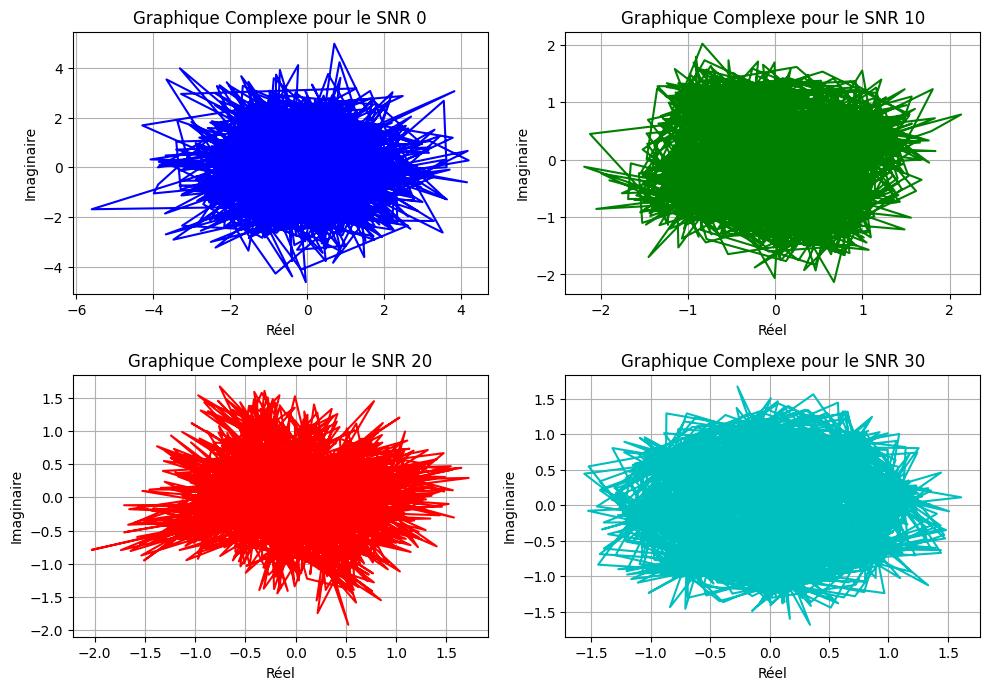

In [79]:
couleurs = ['b', 'g', 'r','c']

plt.figure(figsize=(10, 10))

for i,s in enumerate(unique_snr):
    signal = signal_from_snr(s)

    plt.subplot(3, 2, i+1)  # 3 lignes, 2 colonnes, position i
    plt.plot(signal[:, 0], signal[:, 1], color=couleurs[i])
    plt.title(f'Graphique Complexe pour le SNR {s}')
    plt.xlabel('Réel')
    plt.ylabel('Imaginaire')
    plt.grid(True)

plt.tight_layout()
plt.show()


Les SNR plus élevées indiquent moins de bruit dans le signal, ce qui veut dire que qu'ils correspondent à des signaux plus facilement traitables en terme d'apprentissage et de prédiction.

## Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [81]:
# Récupérer les données selon des SNR données.
def data_from_snr(s_list, data):
    signals = np.array(data["signaux"])
    snr = np.array(data["snr"])
    labels_id = np.array(data["labels"])

    indices = np.where(np.isin(snr, s_list))[0]
    return signals[indices, :, :], labels_id[indices]

In [82]:
signals.shape # [B, T, C]. Mais on veut X.transpose(0, 2, 1) pour [B,C,T] avant le réseau de convolution

(200, 2048, 2)

In [83]:
class MyDataset(torch.utils.data.Dataset):
    # Le dataset contient les signaux et leurs labels dont le SNR est présent dans snr_list.
    def __init__(self, path_to_data,snr_list=[10,20,30]):
      data = h5py.File(path_to_data , 'r')
      self.path_to_data = path_to_data
      self.data = torch.FloatTensor(data_from_snr(snr_list,data)[0])
      self.labels = torch.LongTensor(data_from_snr(snr_list,data)[1])
      data.close()

    def __len__(self): # Retourne le nombre de données (ou taille du batch) dans le dataset
      return len(self.data)
    def __getitem__(self,i): # Retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
      return self.data[i],self.labels[i]

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [84]:
# Test sur sample.hdf5
dataset = MyDataset(data_path,[0,10,20,30])
len(dataset)

200

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [85]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [86]:
batch_sizes = [5, 10, 20, 50]  # Exemple de différentes tailles de batch

for batch_size in batch_sizes:
    print(f"Testing DataLoader with batch_size = {batch_size}")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(f"Number of batches: {math.ceil(len(dataset) / batch_size)}")
    for idx, (data, labels) in enumerate(dataloader):
        print(f"Batch {idx+1}:")
        print(f" - Data shape: {data.shape}")
        print(f" - Labels shape: {labels.shape}")

        if idx == 2:
            break

    print("\n")


Testing DataLoader with batch_size = 5
Number of batches: 40
Batch 1:
 - Data shape: torch.Size([5, 2048, 2])
 - Labels shape: torch.Size([5])
Batch 2:
 - Data shape: torch.Size([5, 2048, 2])
 - Labels shape: torch.Size([5])
Batch 3:
 - Data shape: torch.Size([5, 2048, 2])
 - Labels shape: torch.Size([5])


Testing DataLoader with batch_size = 10
Number of batches: 20
Batch 1:
 - Data shape: torch.Size([10, 2048, 2])
 - Labels shape: torch.Size([10])
Batch 2:
 - Data shape: torch.Size([10, 2048, 2])
 - Labels shape: torch.Size([10])
Batch 3:
 - Data shape: torch.Size([10, 2048, 2])
 - Labels shape: torch.Size([10])


Testing DataLoader with batch_size = 20
Number of batches: 10
Batch 1:
 - Data shape: torch.Size([20, 2048, 2])
 - Labels shape: torch.Size([20])
Batch 2:
 - Data shape: torch.Size([20, 2048, 2])
 - Labels shape: torch.Size([20])
Batch 3:
 - Data shape: torch.Size([20, 2048, 2])
 - Labels shape: torch.Size([20])


Testing DataLoader with batch_size = 50
Number of batches: 

## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

Le modèle simple qu'on va utiliser est un réseau qui consiste en deux couches linéaires. Pour permettre celles-ci d'opérer, on applatit les données d'entrées pour passer de $[B, C_\text{in}, T]$ à $[B, C_\text{in}*T]$.

In [87]:
class DumbNetwork(nn.Module):
    def __init__(self, C_in, T, num_classes):
        super(DumbNetwork, self).__init__()
        self.linear1 = nn.Linear(C_in * T, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1) # [B, C_in, T] -> [B, C_in*T]
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

On n'insère pas de $\texttt{softmax}$ dans le réseau car la fonction de perte qu'on va utiliser effectue déjà cette opération.

In [88]:
#signals
C_in,T,num_classes = signals.shape[2],signals.shape[1],6
dumbnetwork = DumbNetwork(C_in,T,num_classes)
X = torch.FloatTensor(signals.transpose(0,2,1)) # [B,C,T]
dumbnetwork(X) # [B,6]

tensor([[-0.0068,  0.1245, -0.1724,  0.2135, -0.0292, -0.2120],
        [ 0.0725,  0.0131, -0.3294,  0.2454,  0.2626, -0.3158],
        [-0.0478, -0.0797, -0.2204,  0.1734,  0.1782, -0.2333],
        ...,
        [-0.2410,  0.0097, -0.1483,  0.1743,  0.1927, -0.3248],
        [-0.5321, -0.0467,  0.0973,  0.1241, -0.3552, -0.1221],
        [-0.0135, -0.0898, -0.1135,  0.3298, -0.1619, -0.1358]],
       grad_fn=<AddmmBackward0>)

## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [89]:
data_samples_path = "/content/drive/MyDrive/Traitement du signal et Deep Learning/TP3/samples.hdf5"
data_train_path = "/content/drive/MyDrive/Traitement du signal et Deep Learning/TP3/train.hdf5"
data_valid_path = "/content/drive/MyDrive/Traitement du signal et Deep Learning/TP3/validation.hdf5"
data_test_path = "/content/drive/MyDrive/Traitement du signal et Deep Learning/TP3/test.hdf5"

In [90]:
def eval_accuracy(y_pred, y_true):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    return correct / y_true.shape[0]


In [91]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Mettons en place la pipeline d'entraînement, qui va nous servir pour entraîner le modèle prototype mais aussi les modèles plus fournis.

In [92]:
## Mise en place de la pipeline d'entraînement
'''
La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires
'''

C_in = 2;T = 2048;num_classes = 6

model = DumbNetwork(C_in, T, num_classes)  # vous instanciez ici votre modèle

loss = nn.CrossEntropyLoss() # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 10 # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = "/content/dumbmodel.pt" # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

data_train = MyDataset(data_train_path)
data_train.data = data_train.data.permute(0,2,1)
print(len(data_train))
data_valid = MyDataset(data_valid_path)
data_valid.data = data_valid.data.permute(0,2,1)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(n_epochs):

    dataloader_train = DataLoader(data_train,
                        batch_size=516,
                        shuffle=True
                       )
    dataloader_valid = DataLoader(data_valid,
                        batch_size=258,
                        shuffle=True
                       )

    model.train()
    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    for batch_x, batch_y in dataloader_train:

        batch_x = batch_x.to(device)  # [batch_size, T, C]
        batch_y = batch_y.to(device)  # [batch size]

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)  # [batch_size, N_classes]

        l = loss(batch_y_predicted, batch_y)
        train_loss_sum += l.item()  # Cumuler la loss

        train_correct += (batch_y_predicted.argmax(1) == batch_y).sum().item()
        train_total += batch_y.size(0)

        l.backward()
        optimizer.step()

    train_loss_avg = train_loss_sum / len(dataloader_train)  # Calculer la loss moyenne pour l'epoch
    train_losses.append(train_loss_avg)  # Enregistrer la loss moyenne
    train_accuracies.append(train_correct / train_total)
    model.eval()
    valid_loss_sum = 0
    valid_correct = 0
    valid_total = 0
    for batch_x, batch_y in dataloader_valid:

        batch_x = batch_x.to(device)  # [batch_size, T, C]
        batch_y = batch_y.to(device)  # [batch size]

        with torch.no_grad():
            batch_y_predicted = model(batch_x)  # [batch_size, N_classes]

        valid_loss = loss(batch_y_predicted, batch_y).item()
        valid_loss_sum += valid_loss

        valid_correct += (batch_y_predicted.argmax(1) == batch_y).sum().item()
        valid_total += batch_y.size(0)

    valid_loss_avg = valid_loss_sum / len(dataloader_valid)  # Calculer la loss moyenne pour l'epoch
    valid_losses.append(valid_loss_avg)  # Enregistrer la loss moyenne
    valid_accuracies.append(valid_correct / valid_total)

    print("| epoch {} | Avg Train Loss {:5.5f} | Avg Valid Loss {:5.5f} | Train Accuracy {:5.5f} | Valid Accuracy {:5.5f} |".format(epoch,train_loss_avg,valid_loss_avg,train_correct/train_total,valid_correct / valid_total))


print("Optimization finished.")
print("Saving the model...")
torch.save(model, chemin_vers_sauvegarde_model)
print("Saved.")

22340
| epoch 0 | Avg Train Loss 1.79897 | Avg Valid Loss 1.77781 | Train Accuracy 0.18841 | Valid Accuracy 0.20305 |
| epoch 1 | Avg Train Loss 1.45825 | Avg Valid Loss 1.78575 | Train Accuracy 0.49843 | Valid Accuracy 0.23687 |
| epoch 2 | Avg Train Loss 1.11104 | Avg Valid Loss 1.76086 | Train Accuracy 0.63406 | Valid Accuracy 0.26671 |
| epoch 3 | Avg Train Loss 0.74225 | Avg Valid Loss 1.76781 | Train Accuracy 0.78438 | Valid Accuracy 0.29058 |
| epoch 4 | Avg Train Loss 0.44808 | Avg Valid Loss 1.85236 | Train Accuracy 0.90855 | Valid Accuracy 0.29164 |
| epoch 5 | Avg Train Loss 0.24695 | Avg Valid Loss 1.96482 | Train Accuracy 0.97444 | Valid Accuracy 0.29297 |
| epoch 6 | Avg Train Loss 0.13129 | Avg Valid Loss 2.09351 | Train Accuracy 0.99628 | Valid Accuracy 0.29416 |
| epoch 7 | Avg Train Loss 0.07161 | Avg Valid Loss 2.18952 | Train Accuracy 0.99973 | Valid Accuracy 0.28899 |
| epoch 8 | Avg Train Loss 0.04289 | Avg Valid Loss 2.29213 | Train Accuracy 0.99996 | Valid Accur

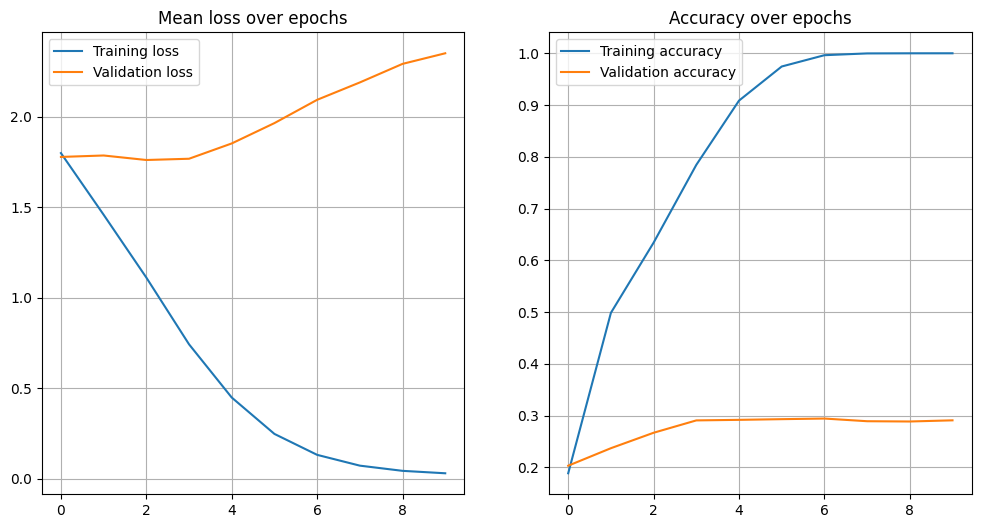

In [93]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Mean loss over epochs')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Validation accuracy')
plt.title('Accuracy over epochs')
plt.grid()
plt.legend()

plt.show()

La perte du jeu de données d'entraînement diminue bien au fil des epochs, ce qui témoigne du fonctionnement de l'optimisation qui a lieu lors des epochs. L'accuracy augmente conjointement pour les données train. En ce qui concerne les données de validation, on observe que la loss augmente très tôt (3 epochs) avec l'accuracy.

In [94]:
data_test = MyDataset(data_test_path)

In [95]:
preds = model(data_test.data.permute(0,2,1).to(device))
labels_pred = preds.argmax(1)
labels_true = data_test.labels.to(device)
print(torch.sum(labels_true==labels_pred)/len(labels_true))

tensor(0.2887, device='cuda:0')


L'accuracy sur les données tests d'envion $29$%. C'est bas mais supérieur à $1/6$ qui serait le résultat si on effectuait une prédiction aléatoire (étant donnée que les classes sont équilibrées). Dans la suite, nous construisons des modèles moins triviaux pour améliorer ce résultat.

## Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Vous pouvez si vous le souhaitez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

In [96]:
C_in = 2;T = 2048;num_classes = 6

Nous crééons 4 modèles, qui prennent en entrée un dataset de taille $[B,C_\text{in},T]$ et renvoient en sortie des logits non normalisés, de taille $[B,6]$

• Un CNN nommé CNN_1 avec 3 couches de convolution munies d'un max pooling. On utilise la fonction d'activation ReLU.

• Un CNN nommé CNN_2, avec les mêmes couches mais une fonction d'activation LeakyReLU.

• Un CNN nommé CNN_3, avec la même structure que CNN_2 mais avec des couches de normalisation en plus.

• Un réseau nommé CNN_RNN, auquel on supprime une couche de convolution pour la remplacer par une couche LSTM. On rajoute également des couches de dropout.

In [122]:
# == MODELE 1 ==
class CNN_1(nn.Module):
    def __init__(self, C_in, T, num_classes=6):
        super(CNN_1, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=C_in, out_channels=32, kernel_size=11, stride=1, padding="same")
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, stride=1, padding="same")
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, stride=1, padding="same")

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        taille = 128 * (T // (2**3))

        self.fc = nn.Linear(taille, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Aplatir les sorties pour la couche dense
        x = self.fc(x)  # Passage à travers la couche fully connected

        return x

# == MODELE 2 ==
class CNN_2(nn.Module):
    def __init__(self, C_in, T, num_classes=6):
        super(CNN_2, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=C_in, out_channels=32, kernel_size=11, stride=1, padding="same")
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, stride=1, padding="same")
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, stride=1, padding="same")

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        taille = 128 * (T // (2**3))

        self.fc = nn.Linear(taille, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Aplatir les sorties pour la couche dense
        x = self.fc(x)  # Passage à travers la couche fully connected

        return x

# == MODELE 3 ==
class CNN_3(nn.Module):
    def __init__(self, C_in, T, num_classes=6):
        super(CNN_3, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=C_in, out_channels=32, kernel_size=11, stride=1, padding="same")
        self.bn1 = nn.BatchNorm1d(32)  # Ajout de la normalisation par batch après conv1
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, stride=1, padding="same")
        self.bn2 = nn.BatchNorm1d(64)  # Ajout de la normalisation par batch après conv2
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=11, stride=1, padding="same")
        self.bn3 = nn.BatchNorm1d(128)  # Ajout de la normalisation par batch après conv3

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        taille = 128 * (T // (2**3))

        self.fc = nn.Linear(taille, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)  # Aplatir les sorties pour la couche dense
        x = self.fc(x)  # Passage à travers la couche fully connected

        return x

#== MODELE 4 ==
class CNN_RNN(nn.Module):
    def __init__(self, C_in, T, num_classes=6, hidden_size=128, num_layers=1, dropout_rate=0.5):
        super(CNN_RNN, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=C_in, out_channels=32, kernel_size=11, stride=1, padding="same")
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, stride=1, padding="same")
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(dropout_rate)

        # RNN layer
        self.rnn = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.dropout(self.pool(F.leaky_relu(self.bn2(self.conv2(x)))))

        x = x.transpose(1, 2)  # Transposer pour que les dimensions correspondent aux attentes du RNN
        x, (hn, cn) = self.rnn(x)

        # Final state
        x = hn[-1]

        x = self.fc(x)

        return x

A partir de la pipeline d'entraînement codée plus tôt, on créer une fonction pour pouvoir entraîner plusieurs modèles de manière flexible. On rajoute comme fonctionnalité un scheduling pour le learning rate, qui est une technique d'ajustement au fil de l'entraînement permettant d'améliorer les performances et la convergence du modèle.

In [124]:
def train_model(model,
                model_name,
                data_train_path,
                data_valid_path,
                data_test_path,
                save_path,
                n_epochs=20,
                batch_size=256,
                lr=0.01,
                ):

    print("======= Training " + model_name + " with ", n_epochs ," epochs =======")
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    loss = nn.CrossEntropyLoss() # définissez la fonction de perte selon laquelle le modèle sera optimisé

    optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


    model.to(device) # on place le modèle dans le GPU si nécessaire

    print("Loading Datasets...")
    data_train = MyDataset(data_train_path,[0,10,20,30])
    data_train.data = data_train.data.permute(0,2,1)

    data_valid = MyDataset(data_valid_path)
    data_valid.data = data_valid.data.permute(0,2,1)
    print("Datasets loaded.")

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(n_epochs):

        dataloader_train = DataLoader(data_train,
                            batch_size=batch_size,
                            shuffle=True
                          )
        dataloader_valid = DataLoader(data_valid,
                            batch_size=batch_size,
                            shuffle=True
                          )

        model.train()
        train_loss_sum = 0
        train_correct = 0
        train_total = 0
        for batch_x, batch_y in dataloader_train:

            batch_x = batch_x.to(device)  # [batch_size, T, C]
            batch_y = batch_y.to(device)  # [batch size]

            optimizer.zero_grad()

            batch_y_predicted = model(batch_x)  # [batch_size, N_classes]

            l = loss(batch_y_predicted, batch_y)
            train_loss_sum += l.item()  # Cumuler la loss

            train_correct += (batch_y_predicted.argmax(1) == batch_y).sum().item()
            train_total += batch_y.size(0)

            l.backward()
            optimizer.step()

        scheduler.step()

        train_loss_avg = train_loss_sum / len(dataloader_train)  # Calculer la loss moyenne pour l'epoch
        train_losses.append(train_loss_avg)  # Enregistrer la loss moyenne
        train_accuracies.append(train_correct / train_total)
        model.eval()
        valid_loss_sum = 0
        valid_correct = 0
        valid_total = 0
        for batch_x, batch_y in dataloader_valid:

            batch_x = batch_x.to(device)  # [batch_size, T, C]
            batch_y = batch_y.to(device)  # [batch size]

            with torch.no_grad():
                batch_y_predicted = model(batch_x)  # [batch_size, N_classes]

            valid_loss = loss(batch_y_predicted, batch_y).item()
            valid_loss_sum += valid_loss

            valid_correct += (batch_y_predicted.argmax(1) == batch_y).sum().item()
            valid_total += batch_y.size(0)

        valid_loss_avg = valid_loss_sum / len(dataloader_valid)  # Calculer la loss moyenne pour l'epoch
        valid_losses.append(valid_loss_avg)  # Enregistrer la loss moyenne
        valid_accuracies.append(valid_correct / valid_total)

        print("| epoch {} | Avg Train Loss {:5.5f} | Avg Valid Loss {:5.5f} | Train Accuracy {:5.5f} | Valid Accuracy {:5.5f} |".format(epoch,train_loss_avg,valid_loss_avg,train_correct/train_total,valid_correct / valid_total))

    torch.save(model, save_path)
    return train_losses,valid_losses, train_accuracies, valid_accuracies

On va entrainer et évaluer trois modèles: CNN_1, CNN_3, et CNN_RNN. Le nombre d'epochs est $23$, la taille des batchs est $256$ et on initalise un learning rate de $0.01$. On fait de plus le choix de ne pas considérer les signaux de SNR $0$ dans l'entraînement, car on estime que ces signaux n'apportent pas d'information.

In [125]:
C_in = 2; T = 2048; n_classes = 6
cnn_1 = CNN_1(C_in, T, n_classes); cnn_3 = CNN_3(C_in, T, n_classes); cnn_rnn = CNN_RNN(C_in, T, n_classes)
models = [cnn_1,cnn_3,cnn_rnn]
models_name = ["CNN_1", "CNN_3","CNN_RNN"]
losses = []
accuracies = []
for i in range(3):
      _,loss_list,_,acc_list = train_model(models[i],models_name[i],data_train_path,data_valid_path,data_test_path,"/content/" + models_name[i] + ".pt",batch_size=256,n_epochs=23,lr=0.001)
      losses.append(loss_list)
      accuracies.append(acc_list)

======= Training CNN_1 with  23  epochs =======
Loading Datasets...
Datasets loaded.
| epoch 0 | Avg Train Loss 1.63691 | Avg Valid Loss 1.12165 | Train Accuracy 0.23190 | Valid Accuracy 0.33714 |
| epoch 1 | Avg Train Loss 1.15717 | Avg Valid Loss 1.10366 | Train Accuracy 0.32757 | Valid Accuracy 0.34894 |
| epoch 2 | Avg Train Loss 1.14134 | Avg Valid Loss 1.10650 | Train Accuracy 0.34003 | Valid Accuracy 0.33541 |
| epoch 3 | Avg Train Loss 1.10900 | Avg Valid Loss 1.09944 | Train Accuracy 0.34753 | Valid Accuracy 0.33488 |
| epoch 4 | Avg Train Loss 1.10447 | Avg Valid Loss 1.10305 | Train Accuracy 0.35203 | Valid Accuracy 0.33064 |
| epoch 5 | Avg Train Loss 1.08450 | Avg Valid Loss 1.02917 | Train Accuracy 0.39207 | Valid Accuracy 0.39867 |
| epoch 6 | Avg Train Loss 1.00644 | Avg Valid Loss 0.72174 | Train Accuracy 0.50347 | Valid Accuracy 0.56950 |
| epoch 7 | Avg Train Loss 0.71514 | Avg Valid Loss 0.54340 | Train Accuracy 0.58983 | Valid Accuracy 0.65676 |
| epoch 8 | Avg Tra

## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test

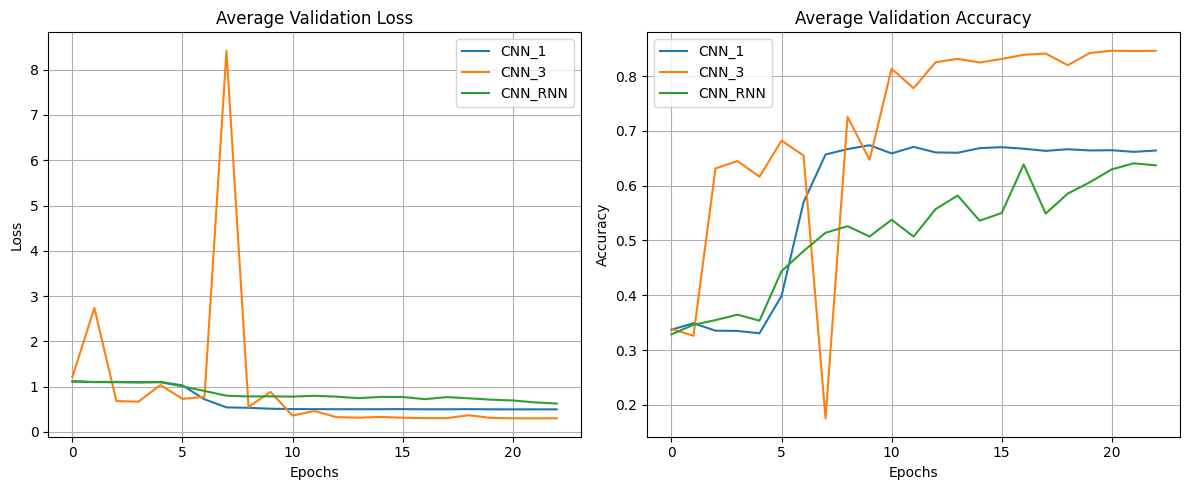

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# losses
for i in range(len(models_name)):
    axes[0].plot(losses[i], label=models_name[i])
axes[0].set_title('Average Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid()
axes[0].legend()

# accuracies
for i in range(len(models_name)):
    axes[1].plot(accuracies[i], label=models_name[i])
axes[1].set_title('Average Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

Ces graphes représentent l'évolution sur la validation de la perte ainsi que de l'accuracy en fonction de l'epoch pour chaque modèle. Pour la fonction de perte, on remarque que CNN_3 est le modèle qui converge le moins rapidement. Il commence par représenter des grosses fluctuations et se stabilise à partir de $12$ epochs. Cependant, c'est le modèle qui converge vers la perte la plus basse au bout de $23$ epochs.

En terme  d'accuracy, c'est ce modèle qui aboutit à la valeur la plus élevée au bout de l'entraînement (environ $85$%). Les autres modèles naviguent à la fin autour de $65$%.

CNN_RNN présente les moins bonnes performances durant l'entraînement. Cela peut être due à la couche LSTM qui réduit les capacités du modèle.

A présent, comparons les résultats sur les données tests.

In [139]:
snr_sets = [[10], [20], [30], [10, 20, 30], [0, 10, 20, 30]]
accuracies_table = []
df_accuracies = pd.DataFrame(columns=models_name, index=[str(snr) for snr in snr_sets])
for snrs in snr_sets:
    accuracies_row = []
    for model in models:
        data_test = MyDataset(data_test_path, snrs)
        dataloader_test = DataLoader(data_test, batch_size=256, shuffle=False)

        total_correct = 0
        total_samples = 0

        model.eval()  # Mettre le modèle en mode évaluation

        with torch.no_grad():
            for batch_x, batch_y in dataloader_test:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                preds = model(batch_x.permute(0,2,1))
                labels_pred = preds.argmax(1)
                total_correct += (labels_pred == batch_y).sum().item()
                total_samples += batch_y.size(0)

        accuracy = total_correct / total_samples
        accuracies_row.append(accuracy)

    df_accuracies.loc[str(snrs)] = accuracies_row

print("Test Accuracy Table (w.r.t SNRs)")
df_accuracies


Test Accuracy Table (w.r.t SNRs)


,CNN_1,CNN_3,CNN_RNN
[10],0.663846,0.772308,0.606538
[20],0.660345,0.867672,0.671552
[30],0.665414,0.880075,0.651504
"[10, 20, 30]",0.663325,0.839314,0.642216
"[0, 10, 20, 30]",0.5953,0.7292,0.5748


Le modèle qui possède l'accuracy le plus élevé est le modèle CNN_3, avec près de $84$% d'accuracy.

Pour ce modèle, l'accuracy devient moins bonne à mesure qu'on considère les SNR faibles (signaux bruités) dans notre prédiction. Par exemple, considérer $0$ dans la liste des SNR baisse le score de 10% en points de pourcentage. Ce qui est logique étant donnée la nature de ces signaux et le fait qu'on n'utilise pas de SNR égale à $0$ dans l'entraînement. De même, considérer seulement une SNR de $10$ amène un score moindre par rapport une SNR de $30$.

Pour les autres modèles, la différence est moins significative à part si on considère des signaux de SNR $0$.

Enfin, représentons pour CNN_3 la matrice de confusion finale sur les données tests.

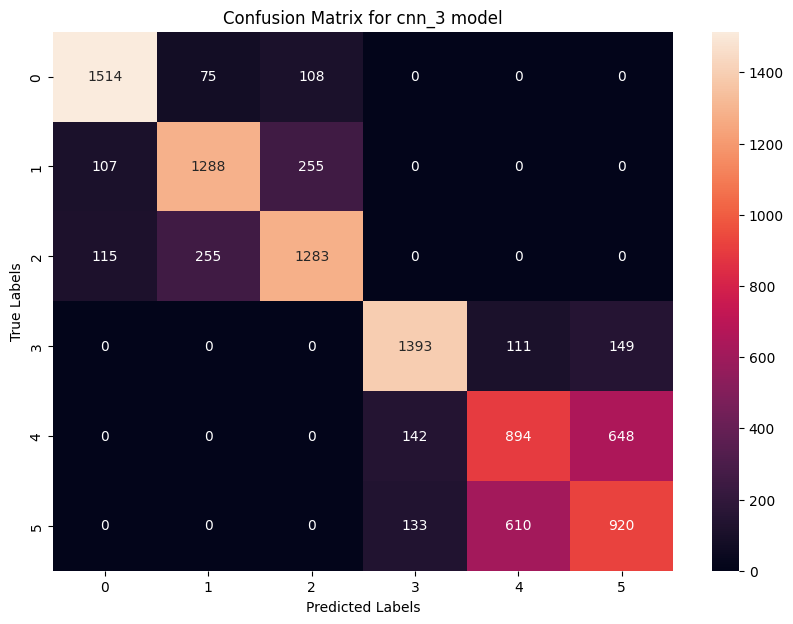

In [141]:
all_preds = []
all_labels = []

cnn_3.eval()

with torch.no_grad():
    for batch_x, batch_y in dataloader_test:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = cnn_3(batch_x.permute(0, 2, 1))
        labels_pred = preds.argmax(1)

        all_preds.extend(labels_pred.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CNN_3 model')
plt.show()

On observe une matrice diagonale par bloc. On remarque des erreurs intra groupes de classes, par exemple entre les classes [0,1,2] et les classes [3,4,5]. Cela peut être due à la structure des signaux.